# QMC Convergence Test for Posterior
**Require: py-ot**
## Setting

Prior: 
- $ \Omega = R^2 $,  $ N(0, I) $ -> leads the Gaussian posterior.
- $ \Omega = [0, 1]^2 $, $ \mu_0 = \text{Uni}(\Omega) $ -> leads the non-Gaussian posterior.


Observation:

$ H: \Omega \ni (x_1, x_2) \mapsto x_1+x_2 \in \mathbb{R}$,

$ y = H(x_1, x_2) + \xi, \quad \xi \sim N(0, 2) $


Task:

Generate $ x^\dagger \sim \mu_0 $, $ \xi^\dagger \sim N(0, 2) $ and set $ y^\dagger = H(x^\dagger) + \xi^\dagger $.

For generated prior samples by QMC, approximate posterior and compute
- mean: $ \bar{x} = \int_\Omega x p(x| y^\dagger) dx $
- variance: $ v = \int_\Omega (x-\bar{x})^2 p(x| y^\dagger) dx $

Reference value is generated by Monte Carlo with sample size $ M = 2^{26} $.

cf: Nonlinear Data Assimilation, 2015

## Grand Truth and Observation

In [168]:
import numpy as np

In [184]:
seed = 10
r = 2
Cov = np.eye(2)
prior_type = 'gauss' # ["uniform", "gauss"]
print(f"prior_type: {prior_type}")

prior_type: gauss


In [185]:
x_true = np.random.rand(2)
xi = np.random.normal(scale=np.sqrt(r))
y = x_true.sum() + xi
print(x_true)

[0.85815591 0.66286145]


## Reference Value

In [186]:
M = 2**26
if prior_type == 'uniform':
    x = np.random.rand(M, 2)
else:
    x = np.random.multivariate_normal(x_true, Cov, M)
hx = x.sum(axis=1)

# compute weights
w = np.exp(-(y-hx)**2/(2*r))
w /= w.sum()

# compute moments
x_ref = w@x
v_ref = w@((x - x_ref)**2).sum(axis=1)

In [187]:
x_ref, v_ref

(array([0.78410707, 0.58852045]), 1.4999603142885019)

## QMC samples

In [188]:
from scipy.stats import qmc

x_qmcs = []
nmax = 10
for n in range(1, nmax+1):
    if prior_type == 'uniform':
        x_qmc = qmc.Sobol(d=2, scramble=False).random_base2(m=n) # M = 2**n
    else:
        x_qmc = qmc.MultivariateNormalQMC(mean=x_true, cov=Cov).random(2**n) # M = 2**n
    x_qmcs.append(x_qmc)

In [189]:
def qmc_test(update_fn, x_qmc_priors, y):
    x_estis = []
    v_estis = []
    for x_prior in x_qmc_priors:        
        x_post = update_fn(x_prior, y, r) # assume equal weighted posterior samples

        # compute moments
        x_esti = x_post.mean(axis=0)
        v_esti = ((x_post - x_esti)**2).sum(axis=1).mean()
        x_estis.append(x_esti)
        v_estis.append(v_esti)

    x_estis = np.array(x_estis)
    v_estis = np.array(v_estis)
    return x_estis, v_estis

## SIR

In [190]:
def sir_update(x_prior, y, r):
    M = x_prior.shape[0]
    hx = x_prior.sum(axis=1)

    # compute weights
    w = np.exp(-(y-hx)**2/(2*r))
    w /= w.sum()

    # resample
    index = np.arange(M)
    reindex = np.random.choice(index, size=M, p=w, replace=True) 
    x_post = x_prior[reindex]
    return x_post

In [191]:
x_sirs, v_sirs = qmc_test(sir_update, x_qmcs, y)

## ETPF

In [192]:
import ot
def etpf_update(x_prior, y, r):
    M = x_prior.shape[0]
    hx = x_prior.sum(axis=1)

    # compute weights
    w = np.exp(-(y-hx)**2/(2*r))
    w /= w.sum()

    # transport
    a = w # source
    b = np.ones(M)/M # target
    dMat = x_prior@x_prior.T
    T = ot.emd(a, b, dMat, numItermax=2*10**5)
    S = M*T # (M, M) = (source, target)
    assert np.allclose(S.sum(axis=0), 1.0)
    x_post = S.T@x_prior # (M, 2)
    
    return x_post

In [193]:
x_ots, v_ots = qmc_test(etpf_update, x_qmcs, y)

## PO

In [194]:
def po_update(x_prior, y, r):
    M = x_prior.shape[0]
    dX = x_prior - x_prior.mean(axis=0)
    hx = x_prior.sum(axis=1)
    H = np.array([1, 1])
    dY = hx - hx.mean()
    y_noise = y + np.random.normal(scale=np.sqrt(r), size=M)
    dy = y_noise - hx # (M, )
    dy = dy.reshape(M, 1)
    # K = PH(HPH+R)^{-1}
    K = dX.T@dY/(dY.T@dY + (M-1)*r)
    K = K.reshape(1, 2)
    x_post = x_prior + dy@K
    return x_post

In [195]:
x_pos, v_pos = qmc_test(po_update, x_qmcs, y)

## ETKF

In [196]:
from scipy.linalg import sqrtm
def etkf_update(x_prior, y, r):
    M = x_prior.shape[0]
    dX = x_prior - x_prior.mean(axis=0) # (M, 2)
    hx = x_prior.sum(axis=1)
    dY = hx - hx.mean()
    dY = dY.reshape(M, 1)
    dy = y - hx.mean() # (1, )
    dy = dy.reshape(1,)
    
    T = sqrtm(np.eye(M) - dY@dY.T/(dY.T@dY+(M-1)*r))
    K = dX.T@dY/(dY.T@dY + (M-1)*r) # (2, 1)
    x_mean = x_prior.mean(axis=0) + (K*dy).ravel()
    x_post = x_mean + (dX.T @ T).T # (M, dim_x)
    return x_post

In [197]:
x_etkfs, v_etkfs = qmc_test(etkf_update, x_qmcs, y)

## Plot

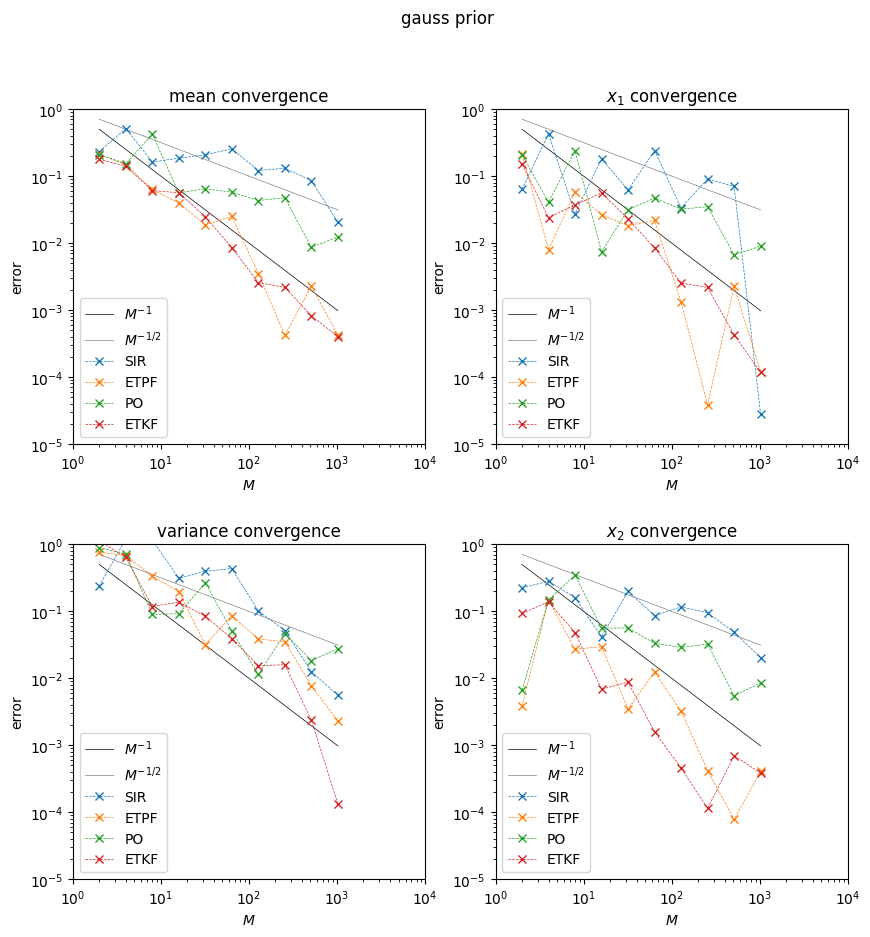

In [199]:
import matplotlib.pyplot as plt
Ms = 2**np.arange(1,nmax+1)

def base_plot(ax):
    ax.plot(Ms, 1/Ms, color="k", label="$ M^{-1} $", linewidth=0.5)
    ax.plot(Ms, 1/Ms**0.5, color="gray", label="$ M^{-1/2} $", linewidth=0.5)
    ax.set_xlabel("$ M $")
    ax.set_ylabel("error")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1, 10**4)
    # ax.set_ylim(1e-6, 1)
    ax.legend()

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f"{prior_type} prior")

ax1 = fig.add_subplot(2, 2, 1)
base_plot(ax1)
ax1.plot(Ms, np.linalg.norm(x_sirs-x_ref, axis=1), marker="x", linestyle="--", label="SIR", linewidth=0.5)
ax1.plot(Ms, np.linalg.norm(x_ots-x_ref, axis=1), marker="x", linestyle="--", label="ETPF", linewidth=0.5)
ax1.plot(Ms, np.linalg.norm(x_pos-x_ref, axis=1), marker="x", linestyle="--", label="PO", linewidth=0.5)
ax1.plot(Ms, np.linalg.norm(x_etkfs-x_ref, axis=1), marker="x", linestyle="--", label="ETKF", linewidth=0.5)
ax1.set_ylim(1e-5, 1)
ax1.set_title("mean convergence")
ax1.legend()

ax2 = fig.add_subplot(2, 2, 3)
base_plot(ax2)
ax2.plot(Ms, np.abs(v_sirs-v_ref), marker="x", linestyle="--", label="SIR", linewidth=0.5)
ax2.plot(Ms, np.abs(v_ots-v_ref), marker="x", linestyle="--", label="ETPF", linewidth=0.5)
ax2.plot(Ms, np.abs(v_pos-v_ref), marker="x", linestyle="--", label="PO", linewidth=0.5)
ax2.plot(Ms, np.abs(v_etkfs-v_ref), marker="x", linestyle="--", label="ETKF", linewidth=0.5)
ax2.set_ylim(1e-5, 1)
ax2.set_title("variance convergence")
ax2.legend()

ax3 = fig.add_subplot(2, 2, 2)
base_plot(ax3)
ax3.plot(Ms, np.abs(x_sirs[:, 0]-x_ref[0]), marker="x", linestyle="--", label="SIR", linewidth=0.5)
ax3.plot(Ms, np.abs(x_ots[:, 0]-x_ref[0]), marker="x", linestyle="--", label="ETPF", linewidth=0.5)
ax3.plot(Ms, np.abs(x_pos[:, 0]-x_ref[0]), marker="x", linestyle="--", label="PO", linewidth=0.5)
ax3.plot(Ms, np.abs(x_etkfs[:, 0]-x_ref[0]), marker="x", linestyle="--", label="ETKF", linewidth=0.5)
ax3.set_ylim(1e-5, 1)
ax3.set_title("$ x_1 $ convergence")
ax3.legend()

ax4 = fig.add_subplot(2, 2, 4)
base_plot(ax4)
ax4.plot(Ms, np.abs(x_sirs[:, 1]-x_ref[1]), marker="x", linestyle="--", label="SIR", linewidth=0.5)
ax4.plot(Ms, np.abs(x_ots[:, 1]-x_ref[1]), marker="x", linestyle="--", label="ETPF", linewidth=0.5)
ax4.plot(Ms, np.abs(x_pos[:, 1]-x_ref[1]), marker="x", linestyle="--", label="PO", linewidth=0.5)
ax4.plot(Ms, np.abs(x_etkfs[:, 1]-x_ref[1]), marker="x", linestyle="--", label="ETKF", linewidth=0.5)
ax4.set_ylim(1e-5, 1)
ax4.set_title("$x_2$ convergence")
ax4.legend()